**Author:** Summer </br>
**Task:** 2D footprint clustering (exterior boundaries of building footprints)

***Taking spatial attributes into account by computing the radius of nodes from the polygon boundary.***

![alt text](./images/radius.png)

## PART I: Skeleton Graph Computation
### **Step 1: Medial Axis Approximation (Approach 4 Point reduction and edge construction in step 1, scikit geometry in step 2)**

**1.1 Load data and plot edges and points**

In [92]:
# import library
import sys
sys.path.append('./WWL/src')
from wwl import wwl
import igraph as ig

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import unary_union
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import networkx as nx
import skgeom as sg
from skgeom.draw import draw
#from scipy.stats import wasserstein_distance
#import ot
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import SpectralClustering

In [93]:
# simplified shp in QGIS using the simplify tool
# dissovled boundaries to obtain exterior boundary of each footprint
# load simplified shp
sim_buildings_ext_gdf = gpd.read_file("./data/output/sim_buildings_ext_boundary_diss.shp")
sim_buildings_ext_gdf

,blockID,stories,materials,geometry
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24..."
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9..."
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5..."
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2..."
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24..."
...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4..."
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1..."
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80..."
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1..."


In [94]:
sim_buildings_ext_gdf.explore(tiles='CartoDB Positron')

In [95]:
# placing points on the vertices where an edge changes direction, constructing edges between vertices
def sample_points_at_vertices(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    all_vertex_points = []
    all_edges = []

    for idx, row in gdf.iterrows():
        geom = row.geometry # extracts the geometry (i.e., building footprint) from the row in the gdf

        # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
        if geom is None or not isinstance(geom, (Polygon, MultiPolygon)):
            print(idx)
            print(geom)
            continue

        # if the geometry is a multipolygon, merge them into a single polygon
        if isinstance(geom, MultiPolygon):
            geom = unary_union(geom)

        exterior_coords = list(geom.exterior.coords) # get the coordinates of the outer boundary of the polygon, in a sequence of (x,y) tuples
        coords = exterior_coords[:-1]
        vertex_points = [Point(xy) for xy in exterior_coords[:-1]]  # convert each (x,y) coordinate into a Point object, exclude the last coordinate since it duplicates the first (to close the polygon)
        all_vertex_points.extend(vertex_points) # add all the Point objects of a polygon to the list all_vertex_points

        # Create edges between consecutive vertices
        edges = [LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        # Add edge between the last and first to close the polygon
        edges.append(LineString([coords[-1], coords[0]]))

        all_edges.extend(edges)

    # Return GeoDataFrames for points and edges
    points_gdf = gpd.GeoDataFrame(geometry=all_vertex_points, crs=gdf.crs)
    edges_gdf = gpd.GeoDataFrame(geometry=all_edges, crs=gdf.crs)

    return gdf, points_gdf, edges_gdf

In [96]:
# load building footprint for cleaning - ext boundaries
sim_buildings_ext_gdf, sim_points_ext_gdf, sim_edges_ext_gdf = sample_points_at_vertices("./data/output/simplified_dissolved/sim_buildings_ext_boundary_diss.shp")

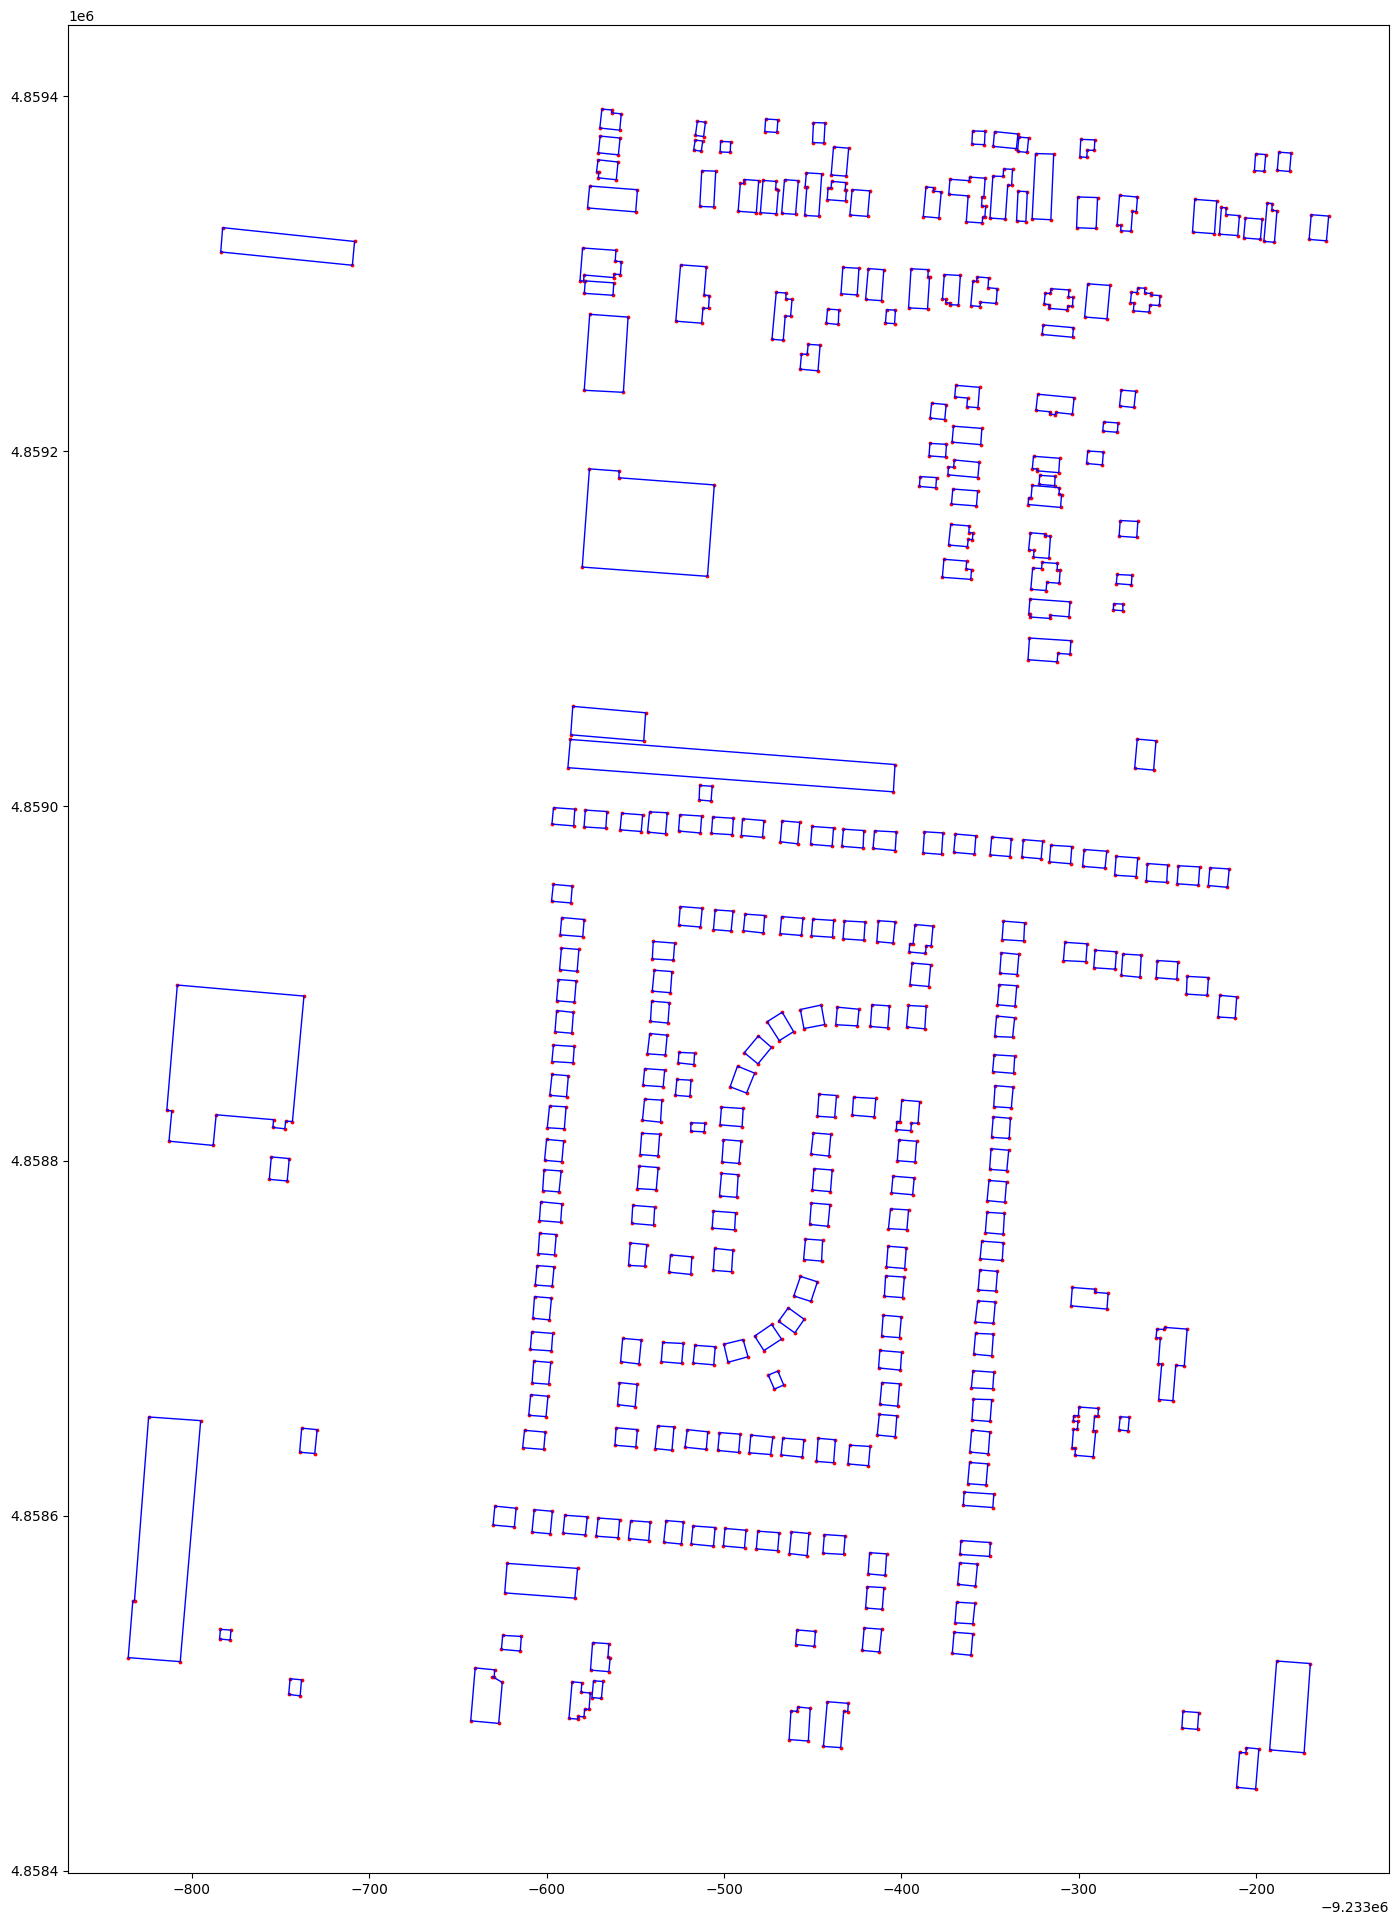

In [97]:
# plot
fig, ax = plt.subplots(figsize=(24, 24))
sim_edges_ext_gdf.plot(ax=ax, edgecolor='blue', linewidth=1, facecolor='none')
sim_points_ext_gdf.plot(ax=ax, color='red', markersize=3)
#plt.savefig("./data/output/for_ext_bound_vetices_edges_reduced_points.png", dpi=1200, bbox_inches='tight')
plt.show()

**1.2 Medial axis construction**

In [98]:
def draw_all_skeletons(polygon, all_skeletons, show_time=False, figsize=(24,24)):
    plt.figure(figsize=figsize)
    draw(polygon, line_width=0.5)
    
    for item in all_skeletons:

        if item is None:
            continue
        
        for h in item.halfedges:
            if h.is_bisector:
                p1 = h.vertex.point
                p2 = h.opposite.vertex.point
                plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=0.5)

        if show_time:
            for v in skeleton.vertices:
                plt.gcf().gca().add_artist(plt.Circle(
                    (v.point.x(), v.point.y()),
                    v.time, color='blue', fill=False))
    return plt

In [99]:
all_poly = []
all_skeleton = []

for idx, row in sim_buildings_ext_gdf.iterrows():
    geom = row.geometry
    #print(geom)

    # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
    if geom is None or not isinstance(geom, (Polygon, MultiPolygon)): 
        print(idx)
        print(geom)
        continue

    # continue to work with geom that is not null
    # for each geom, extract the points and convert them to sg.Point2; use the points to create and draw poly; create the skeleton for each geom
    points = []
    for x,y in geom.boundary.coords[:-1]: # [:-1] to exclude the last point that is used to close the polygon
        points.append(sg.Point2(x,y))
         
    poly = sg.Polygon(points[::-1]) # reverse order of the points    
    all_poly.append(poly)
    skel = sg.skeleton.create_interior_straight_skeleton(poly)        
    all_skeleton.append(skel)

#print(idx)
#print(all_poly)
#len(all_poly)

In [100]:
for idx, x in enumerate(all_skeleton):
    if x == None:
        print(idx, x)

<module 'matplotlib.pyplot' from '/home/summerha/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

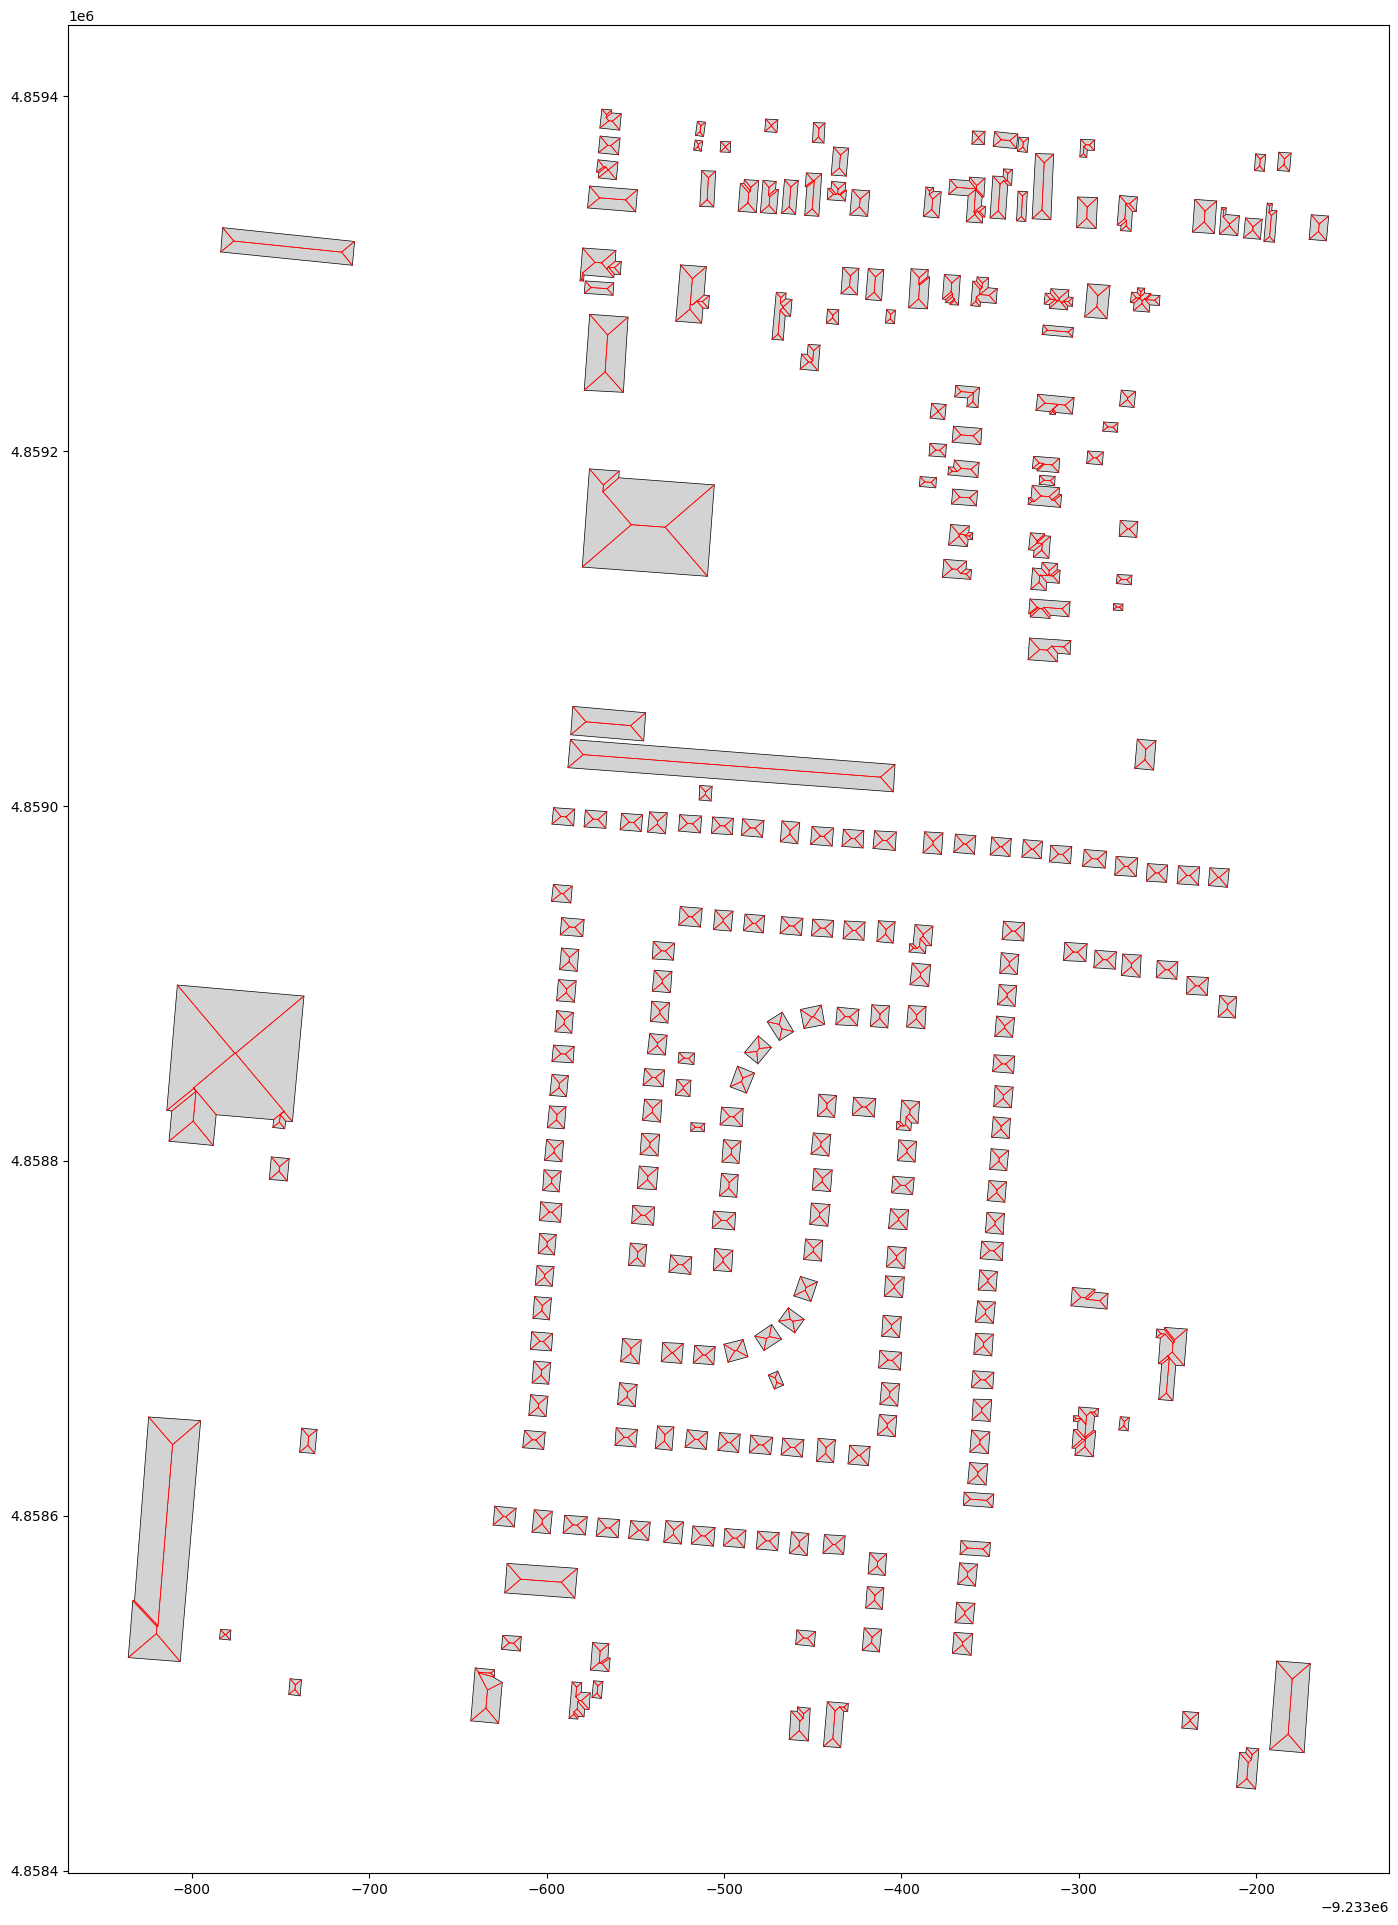

In [101]:
draw_all_skeletons(all_poly,all_skeleton)
#plt.savefig("./data/output/repaired_ext_bound_scikit_geom.png", dpi=1200, bbox_inches='tight')

- From skeleton to networkx graphs and igraph graphs.

In [102]:
### function #2: Convert skeleton graphs to networkx graphs
def skeleton2igraph(skeleton):
    geom_vertices = list(skeleton.vertices)
    geom_edges = list(skeleton.halfedges)

    # create an empty graph with no nodes and no edges
    G=nx.Graph()

    # grow undirected (since it adds up from both direction) graph G by adding edge, done by specifying the vertex id at two ends to determine the edge
    for item in geom_edges:
        if item.is_bisector:
            p1 = item.vertex.id # vertex id
            p2 = item.opposite.vertex.id
            G.add_edge(p1, p2)
    #nx.draw(G, with_labels=True)
    igraph = ig.Graph.from_networkx(G)
    return igraph

In [103]:
all_igraphs = []

for i in all_skeleton:
    all_igraphs.append(skeleton2igraph(i))

all_igraphs

## PART II: Clustering

**2.1 Graph Embedding - From skeleton to graph features**

In [104]:
all_graphs_feature = []

for skeleton in all_skeleton:
    graph_feature = []
    for vertex in list(skeleton.vertices):
        graph_feature.append([vertex.time])
    all_graphs_feature.append(graph_feature)

all_graphs_feature

[[[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [14.242870092967763],
  [14.645540455197322],
  [14.728727658714066],
  [14.736970654916865]],
 [[0.0], [0.0], [0.0], [0.0], [2.76358492677836], [2.769821227779974]],
 [[0.0], [0.0], [0.0], [0.0], [6.747976774744137], [6.858177803181223]],
 [[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [2.0255263887972346],
  [2.1027296110401936],
  [2.332117013741329],
  [7.920892516114367],
  [7.940983367177611]],
 [[0.0], [0.0], [0.0], [0.0], [4.025856252785827], [4.0642355501811585]],
 [[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [2.5427346161882536],
  [2.573588385916939],
  [2.769327582240554],
  [2.8092298404182663],
  [4.161179432337649],
  [4.168435987164082],
  [4.728925484345941],
  [4.750738116667312]],
 [[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [4.253664165210792],
  [4.408466360041671],
  [4.624123064300488],
  [4.636537105296418]],
 [[0.0], [0.0], [0.0], [0

**2.2 Weisfeiler-Lehman Label Propagation**

This `wwl()` function stands for Wasserstein Weisfeiler-Lehman Graph Kernels, which performs Weisfeiler-Lehman Label Propagation and compute Wasserstein Distance at the same time. The output is an adjacency matrix that can be directly used to compute Laplacian matrix ($L = D - A$).

In [105]:
# compute the kernel
kernel_matrix_A = wwl(all_igraphs,node_features=all_graphs_feature, num_iterations=4)

INFO:root:Continuous node features provided, using CONTINUOUS propagation scheme.


In [106]:
# construct laplacian matrix, L = D - A
# compute D
D = np.diag(kernel_matrix_A.sum(axis=1))
print(D)

[[  8.95222676   0.           0.         ...   0.           0.
    0.        ]
 [  0.         190.8956111    0.         ...   0.           0.
    0.        ]
 [  0.           0.         190.97081957 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  10.42560231   0.
    0.        ]
 [  0.           0.           0.         ...   0.         203.87168522
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  204.31921408]]


**Laplacian matrix**

In [107]:
# compute L
L = D - kernel_matrix_A
print(L)

[[ 7.95222676e+00 -2.93157197e-02 -3.04071944e-02 ... -7.78327047e-01
  -2.41796730e-02 -2.41396621e-02]
 [-2.93157197e-02  1.89895611e+02 -7.48482354e-01 ... -3.63032208e-02
  -7.50578144e-01 -7.28548545e-01]
 [-3.04071944e-02 -7.48482354e-01  1.89970820e+02 ... -3.76548521e-02
  -7.43891281e-01 -7.81410466e-01]
 ...
 [-7.78327047e-01 -3.63032208e-02 -3.76548521e-02 ...  9.42560231e+00
  -2.99429799e-02 -2.98934323e-02]
 [-2.41796730e-02 -7.50578144e-01 -7.43891281e-01 ... -2.99429799e-02
   2.02871685e+02 -7.71811735e-01]
 [-2.41396621e-02 -7.28548545e-01 -7.81410466e-01 ... -2.98934323e-02
  -7.71811735e-01  2.03319214e+02]]


**K-mean clustering**

- *Eigengap heuristic for finding the optimal number of clusters*

This paper by [von Luxburg (2007)](https://link.springer.com/content/pdf/10.1007/s11222-007-9033-z.pdf) proposes an approach based on perturbation theory and spectral graph theory to calculate the optimal number of clusters. Eigengap heuristic suggests the number of clusters *k* is usually given by the value of *k* that maximizes the eigengap (difference between consecutive eigenvalues). The larger this eigengap is, the closer the eigenvectors of the ideal case and hence the better spectral clustering works.

References for implementing the code below: [Spectral graph clustering and optimal number of clusters estimation](https://medium.com/data-science/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe).

In [108]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.xlim(0, 10)  # Set x-axis to show from 1 to 10
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters: [  1   2 251   4 252]


/tmp/ipykernel_100758/3834166893.py:27: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)


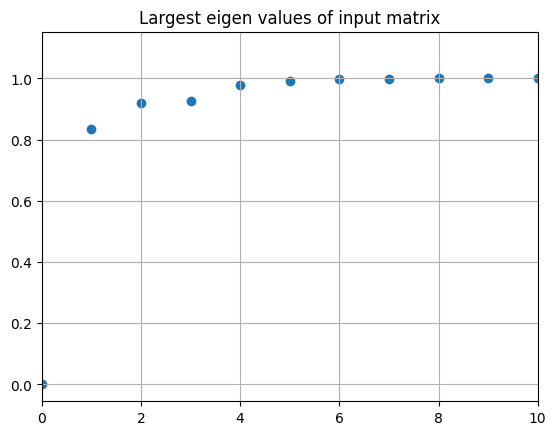

In [109]:
k, _, _ = eigenDecomposition(kernel_matrix_A)
print(f"Optimal number of clusters: {k}")

- *n*=6

In [110]:
clsutering_6 = SpectralClustering(n_clusters=6, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix_A)
y_pred_6 = clsutering_6.labels_.astype(int)

In [111]:
sim_buildings_ext_gdf['cluster_6'] = y_pred_6
sim_buildings_ext_gdf['cluster_6'] = sim_buildings_ext_gdf['cluster_6'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_6
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",4
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",5
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",5
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",4
...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",5
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",2


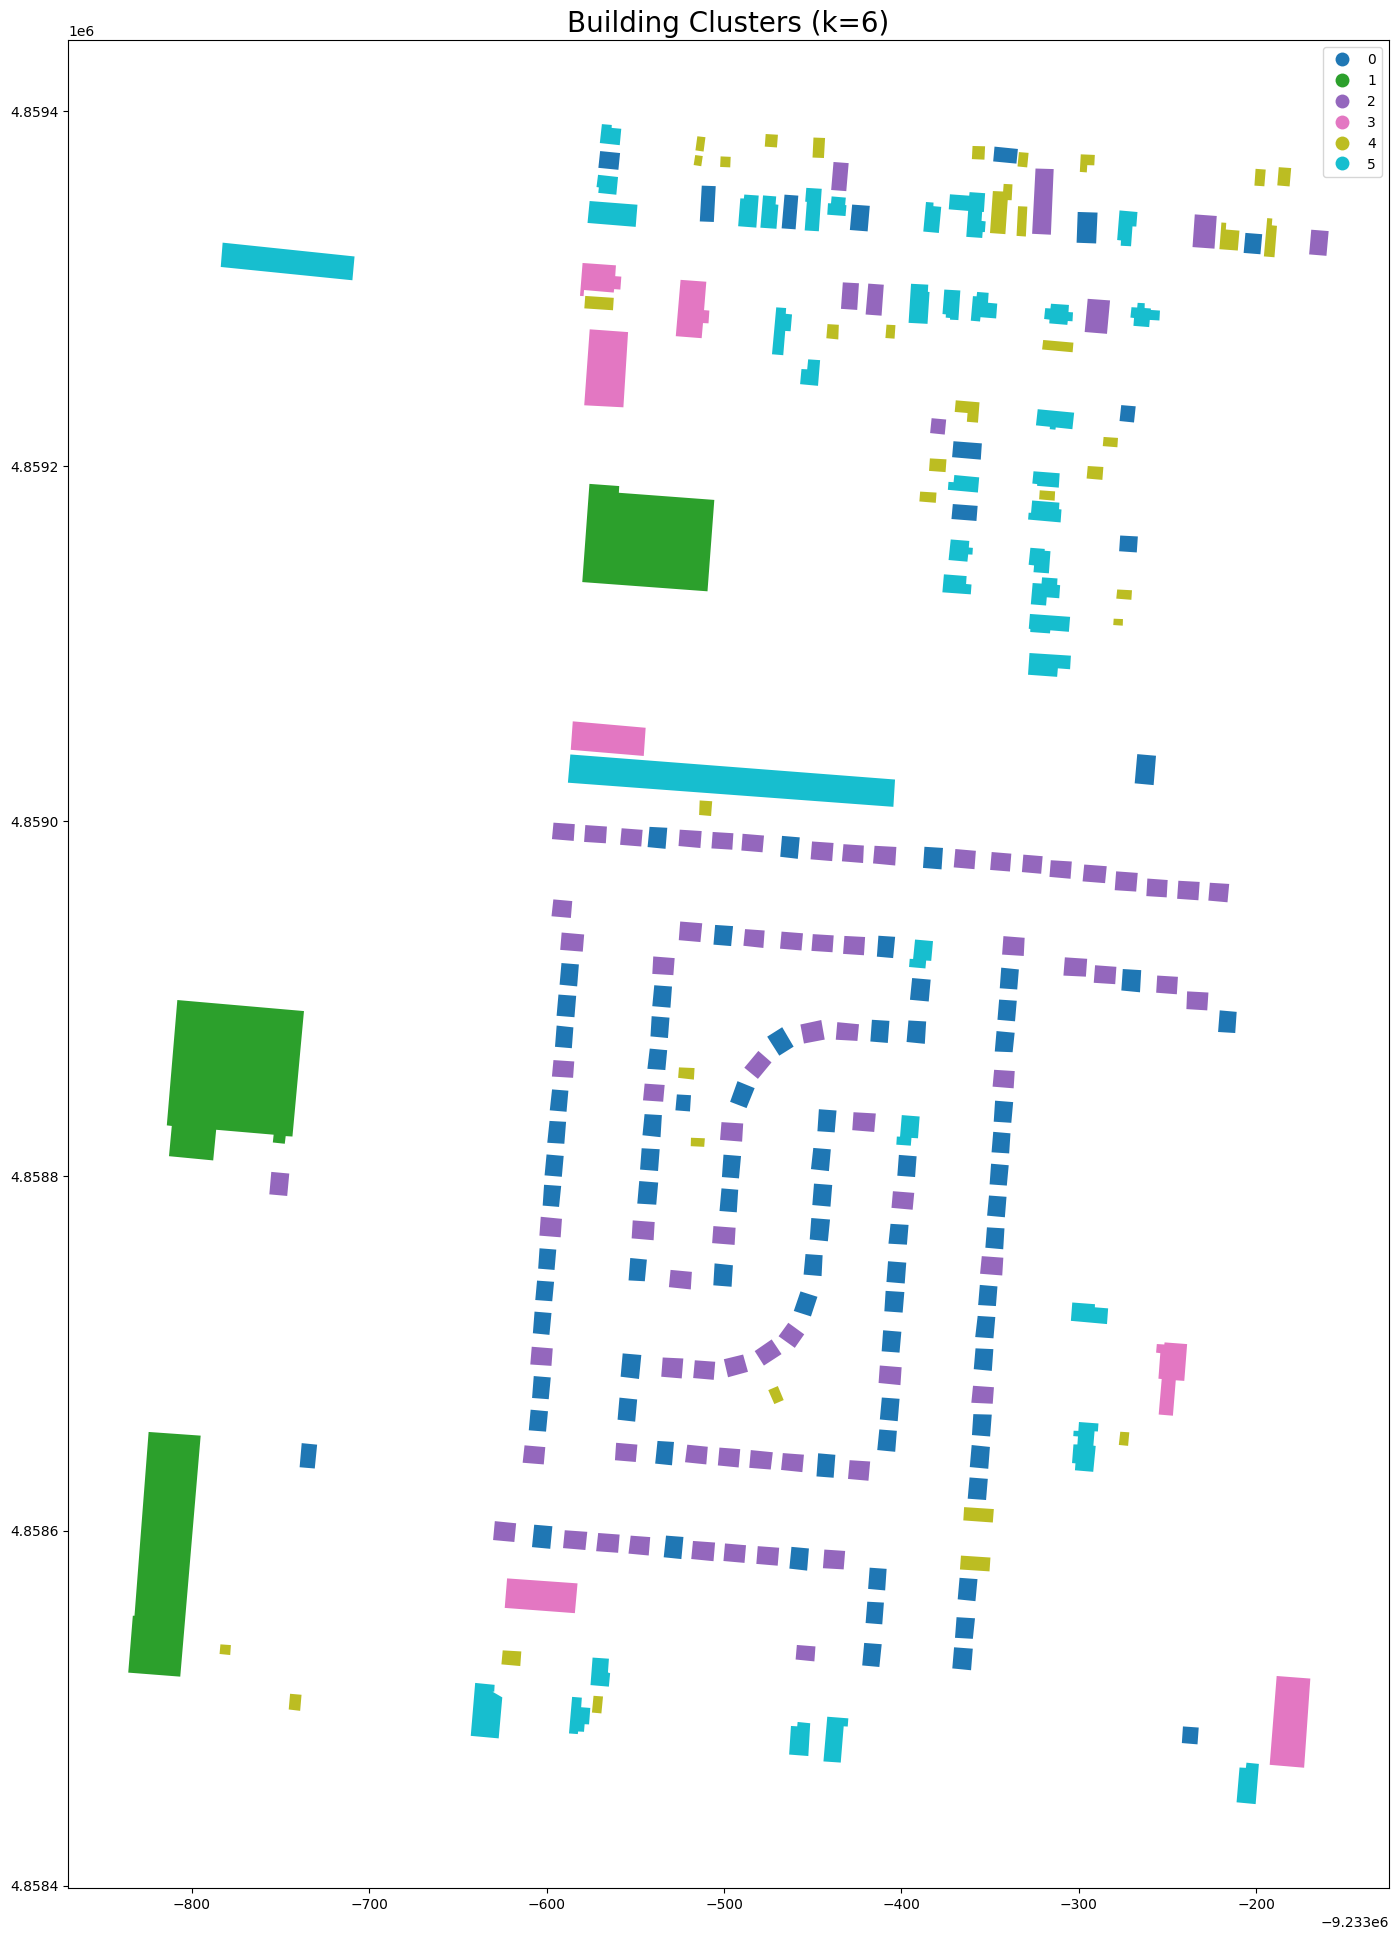

In [112]:
sim_buildings_ext_gdf.plot(column='cluster_6', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=6)", fontsize=20)
plt.savefig("./data/output/clusters_spatial_att_k6.png", dpi=1200, bbox_inches='tight')

- *n*=4

In [113]:
clsutering_4 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix_A)
y_pred_4 = clsutering_4.labels_.astype(int)

In [114]:
sim_buildings_ext_gdf['cluster_4'] = y_pred_4
sim_buildings_ext_gdf['cluster_4'] = sim_buildings_ext_gdf['cluster_4'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_6,cluster_4
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,1
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",4,3
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",5,3
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",5,3
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",4,2
...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",5,3
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",2,2


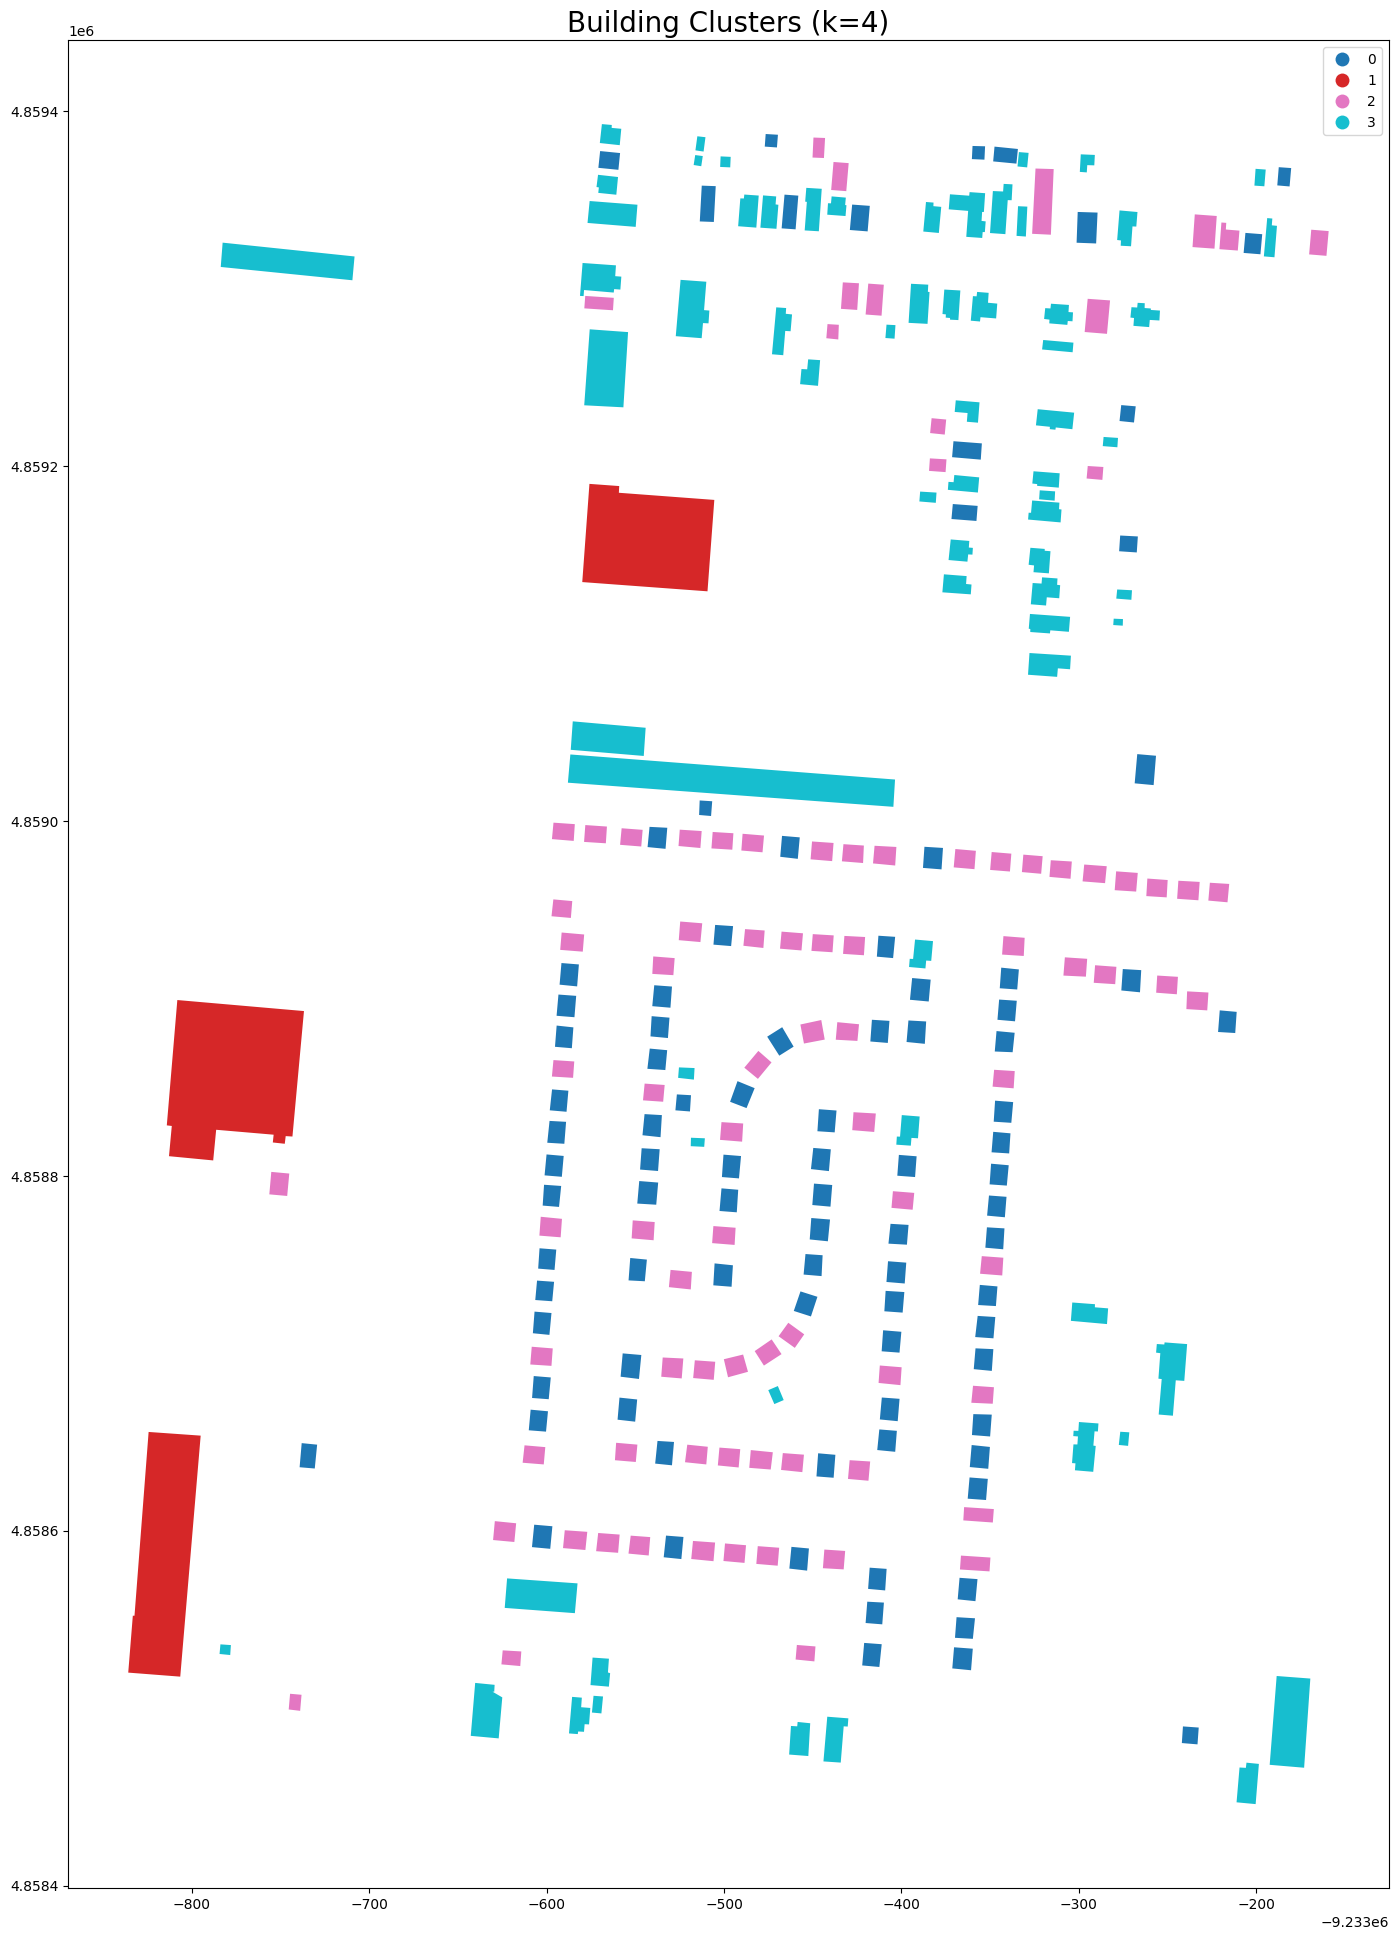

In [120]:
sim_buildings_ext_gdf.plot(column='cluster_4', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=4)", fontsize=20)
#plt.savefig("./data/output/clusters_spatial_att_k4.png", dpi=1200, bbox_inches='tight')

- *n*=3

In [116]:
clsutering_3 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix_A)
y_pred_3 = clsutering_3.labels_.astype(int)

In [117]:
sim_buildings_ext_gdf['cluster_3'] = y_pred_3
sim_buildings_ext_gdf['cluster_3'] = sim_buildings_ext_gdf['cluster_3'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_6,cluster_4,cluster_3
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,1,1
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",4,3,2
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",5,3,2
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",5,3,2
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",4,2,2
...,...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",5,3,2
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",2,2,2


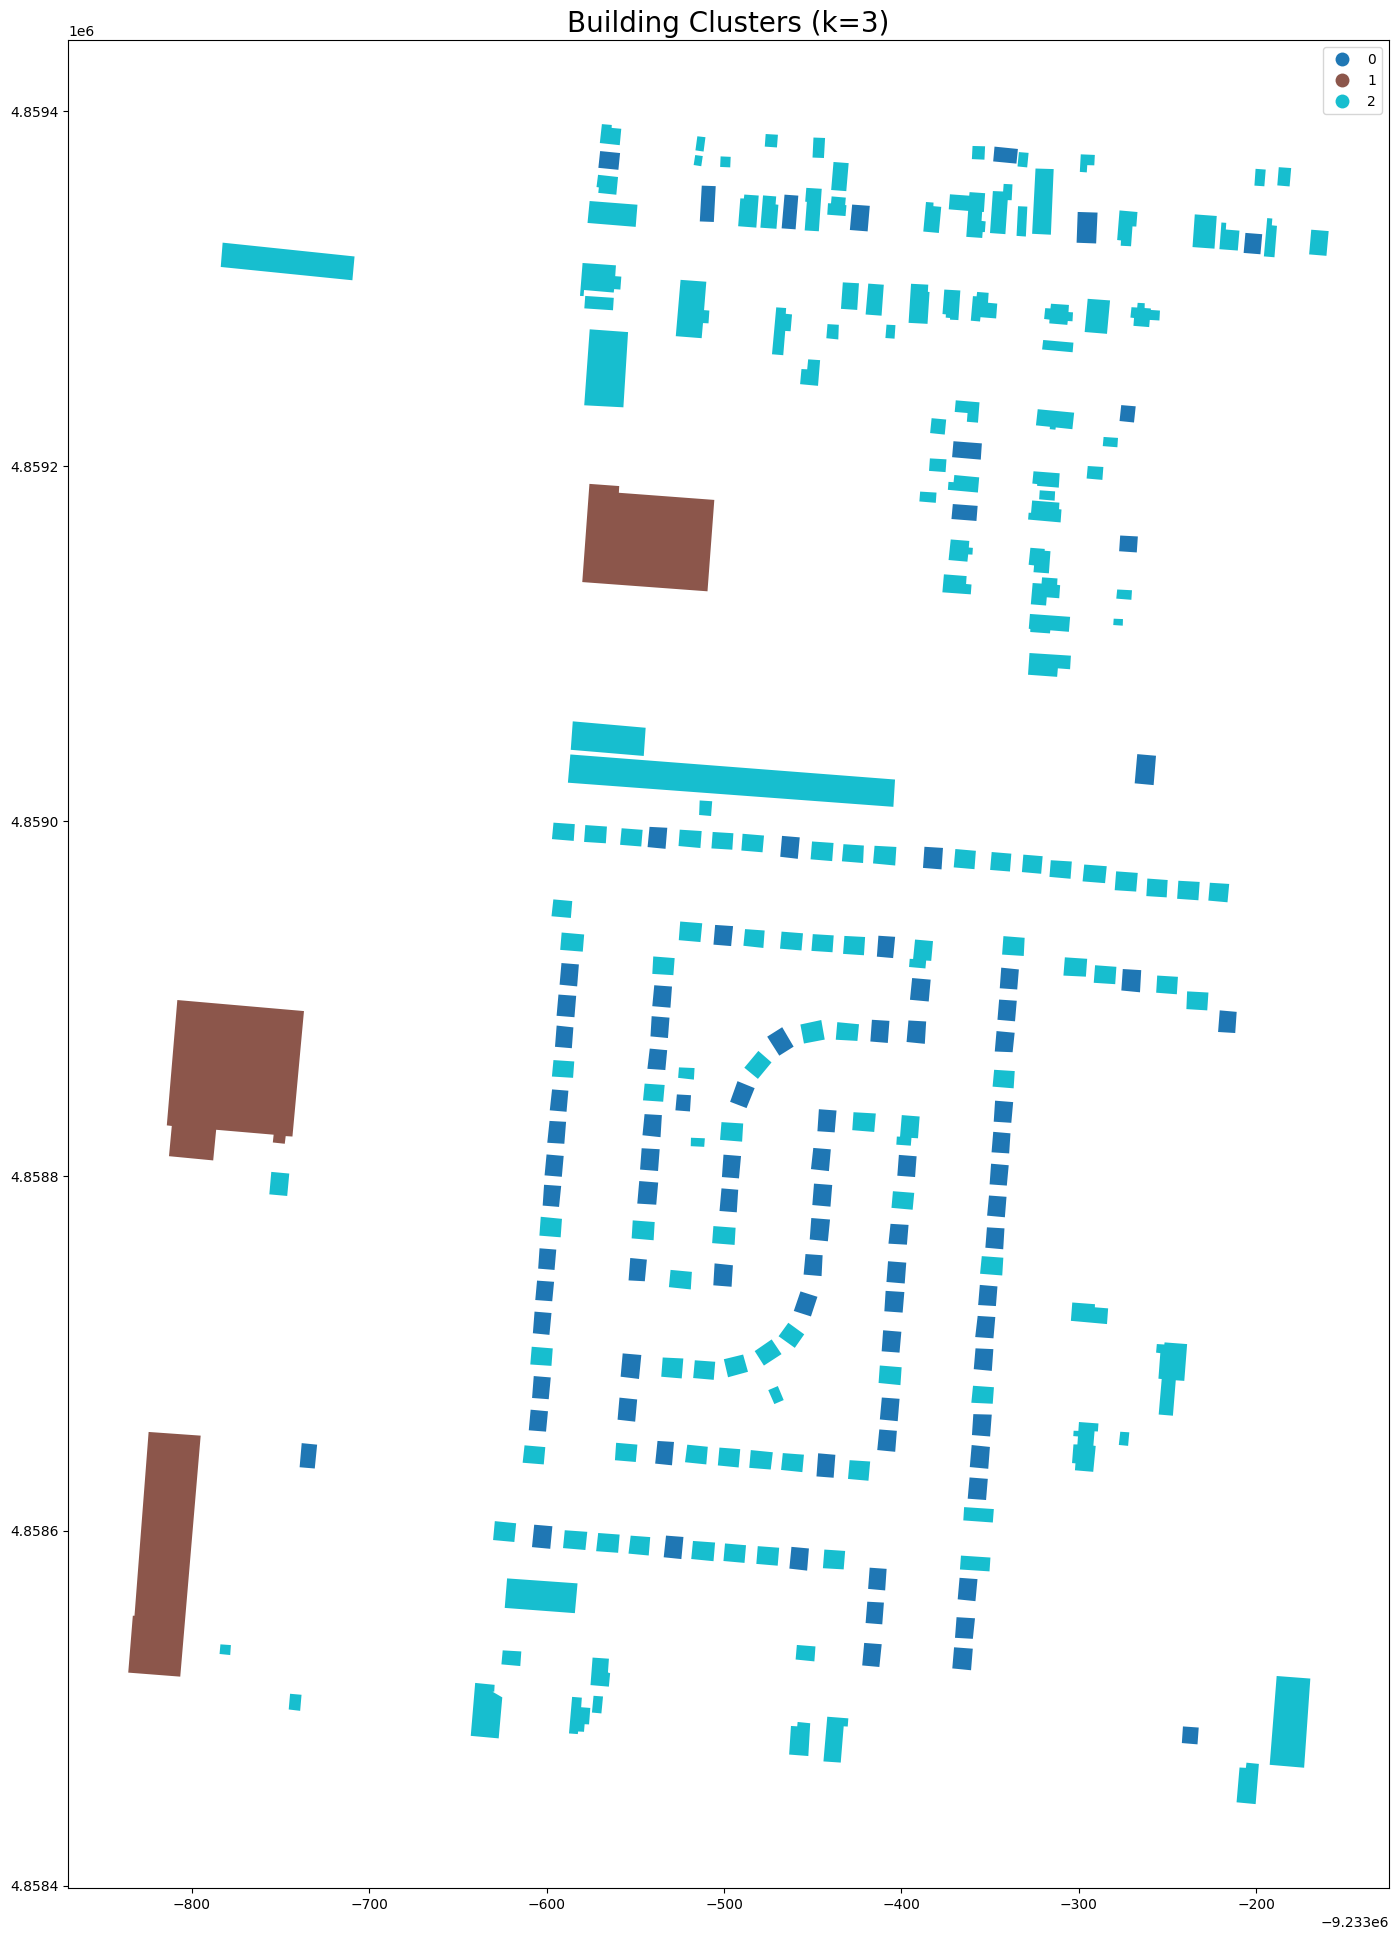

In [121]:
sim_buildings_ext_gdf.plot(column='cluster_3', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=3)", fontsize=20)
#plt.savefig("./data/output/clusters_spatial_att_k3.png", dpi=1200, bbox_inches='tight')

- *n*=2

In [122]:
clsutering_2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix_A)
y_pred_2 = clsutering_2.labels_.astype(int)

In [123]:
sim_buildings_ext_gdf['cluster_2'] = y_pred_2
sim_buildings_ext_gdf['cluster_2'] = sim_buildings_ext_gdf['cluster_2'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_6,cluster_4,cluster_3,cluster_2
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,1,1,1
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",4,3,2,0
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",5,3,2,0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",5,3,2,0
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",4,2,2,0
...,...,...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0,0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",5,3,2,0
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1,1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",2,2,2,0


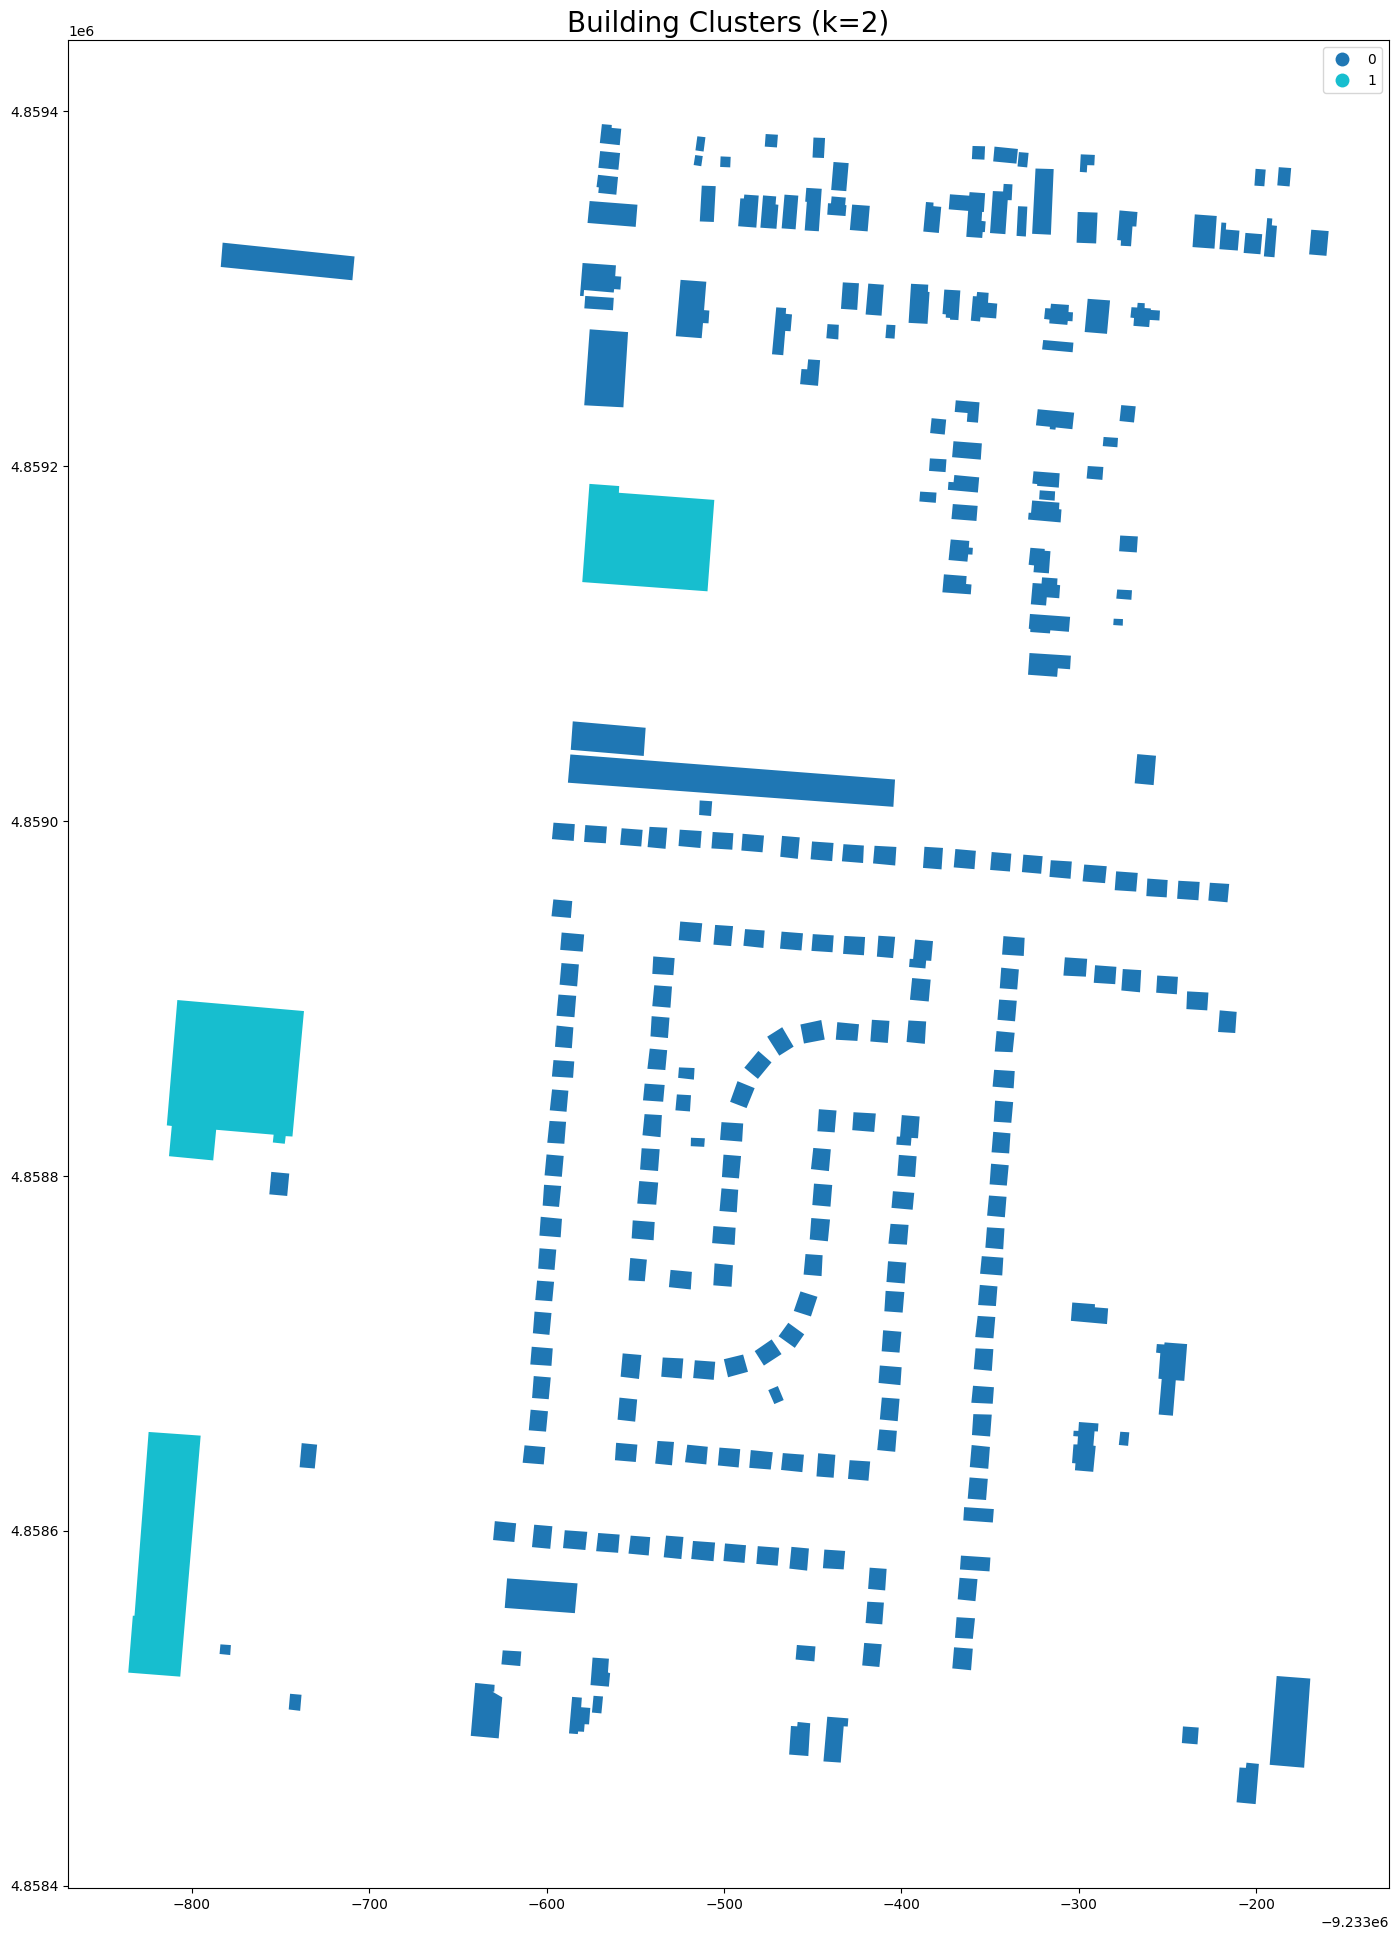

In [124]:
sim_buildings_ext_gdf.plot(column='cluster_2', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=2)", fontsize=20)
plt.savefig("./data/output/clusters_spatial_att_k2.png", dpi=1200, bbox_inches='tight')